# Chapter 3: Coding Attention

<img src="imgs/steps.png" width="50%">

# 3.1 Problem of modeling long sequences

- The big limitation of encoder–decoder RNNs is that the RNN can’t directly access earlier hidden states from the encoder during the decoding phase.  This can lead to a loss of context, especially in complex sentences where dependencies might span long distances.


# 3.2 Capturing data dependencies with attention mechanisms

Although RNNs work fine for translating short sentences, they don’t work well for longer texts as they don’t have direct access to previous words in the input. One major shortcoming in this approach is that the RNN must remember the entire encoded input in a single hidden state before passing it to the decoder

- Hence, researchers developed the Bahdanau attention mechanism for RNNs which modifies the encoder–decoder RNN such that the decoder can selectively access different parts of the input sequence at each decoding step as illustrated in figure 3.5. 

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/05.webp" width="500px">

Interestingly, only three years later, researchers found that RNN architectures are not required for building deep neural networks for natural language processing and proposed the original transformer architecture

# 3.3 Attending to different parts of the input with self-attention

## 3.3.1 A simple self-attention mechanism without trainable weights

- The goal of self-attention is to compute a context vector for each input element that combines information from all other input elements. 

In [2]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/08.webp" width="700px">

In [8]:
query = inputs[1]  # 2nd input token is the query
attn_scores_2 = [ torch.dot(x_i, query) for x_i in inputs ]
attn_scores_2 = torch.stack(attn_scores_2)

In [9]:
attn_scores_2

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

In [10]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

In [11]:
attn_weights_2_tmp

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])

The main goal behind the normalization is to obtain attention weights that sum up to 1. This normalization is a convention that is useful for interpretation and maintaining training stability in an LLM

**In practice, it’s more common and advisable to use the softmax function for normalization.**

In [12]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

In [13]:
attn_weights_2_naive

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

In addition, the softmax function ensures that the attention weights are always positive. This makes the output interpretable as probabilities or relative importance, where higher weights indicate greater importance.

In [14]:
# Better to use pytorch's implementation
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/10.webp" width="700px">

In [29]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


In [ ]:
# Similar way of calculating it
context_vec_2 = [ attn_weights_2[idx] * x_i for idx, x_i in enumerate(inputs) ]
context_vec_2 = torch.stack(context_vec_2)
context_vec_2 = context_vec_2.sum(dim=0)
context_vec_2

tensor([0.4419, 0.6515, 0.5683])

In [33]:
inputs.shape

torch.Size([6, 3])

### 3.3.2 COmputing all attention weights for all input tokens

In [34]:
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [36]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [37]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)


tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [38]:
attn_weights_2


tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

In [43]:
row_2_sum = sum(attn_weights[2].tolist())
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=-1))

Row 2 sum: 1.0000000521540642
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


Use weights to compute the context vectors

In [44]:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


## 3.4 Implementing self-attention (Scaled Dot Product)

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/14.webp" width="600px">

In [45]:
x_2 = inputs[1] # second input element
d_in = inputs.shape[1] # the input embedding size, d=3
d_out = 2 # the output embedding size, d=2

In [46]:
x_2

tensor([0.5500, 0.8700, 0.6600])

In [47]:
d_in

3

In [48]:
d_out

2

**Weight matrices**

In [49]:
torch.manual_seed(123)

W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [50]:
W_query.shape

torch.Size([3, 2])

In [51]:
x_2.shape

torch.Size([3])

In [52]:
query_2 = x_2 @ W_query # _2 because it's with respect to the 2nd input element
key_2 = x_2 @ W_key 
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In matricial form

In [53]:
keys = inputs @ W_key 
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [54]:
inputs.shape

torch.Size([6, 3])

In [55]:
W_key.shape

torch.Size([3, 2])

In [56]:
keys.shape

torch.Size([6, 2])

**Building attention scores**

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/15.webp" width="600px">

In [58]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


**Building attention weights** Justification of the SCALED DOT PRODUCT

The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. 

**As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero.**

In [59]:
keys.shape

torch.Size([6, 2])

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/17.webp" width="600px">

In [60]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


Calculate the final context vector of the second token as a weighted sum of the values

In [63]:
attn_weights_2.shape

torch.Size([6])

In [64]:
values.shape

torch.Size([6, 2])

In [61]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


### 3.4.2 Compact Self-Attention Class

In [65]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [66]:
inputs.shape

torch.Size([6, 3])

In [69]:
outputs = sa_v1(inputs)
outputs.shape

torch.Size([6, 2])

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/18.webp" width="700px">

### Self-Attention Using Linear Layers in Pytorch

In [141]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False, debug=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        if debug:
            fill_num = 1.0
            self.W_query.weight.data.fill_(fill_num)
            self.W_key.weight.data.fill_(fill_num)
            self.W_value.weight.data.fill_(fill_num)


    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

# torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.2061,  0.3977],
        [-0.2032,  0.3992],
        [-0.2032,  0.3991],
        [-0.2039,  0.3977],
        [-0.2044,  0.3967],
        [-0.2035,  0.3986]], grad_fn=<MmBackward0>)


In [127]:
# Reproduce forward
x = inputs

keys = sa_v2.W_key(x)
queries = sa_v2.W_query(x)
values = sa_v2.W_value(x)

In [128]:
x.shape

torch.Size([6, 3])

In [129]:
keys.shape

torch.Size([6, 2])

In [130]:
queries.shape

torch.Size([6, 2])

In [131]:
attn_scores = queries @ keys.T

In [132]:
queries

tensor([[-0.4492,  0.0230],
        [-0.6321, -0.3138],
        [-0.6303, -0.3011],
        [-0.3307, -0.2371],
        [-0.4210,  0.0120],
        [-0.3716, -0.3678]], grad_fn=<MmBackward0>)

In [133]:
attn_scores.shape  # Dim: (seq_len, seq_len)

torch.Size([6, 6])

In [134]:
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

In [135]:
attn_scores

tensor([[-0.1747, -0.2454, -0.2354, -0.1551,  0.0117, -0.2603],
        [-0.3044, -0.3563, -0.3361, -0.2332,  0.1231, -0.4407],
        [-0.3015, -0.3549, -0.3350, -0.2320,  0.1191, -0.4369],
        [-0.1716, -0.1887, -0.1768, -0.1252,  0.0869, -0.2462],
        [-0.1653, -0.2303, -0.2207, -0.1457,  0.0139, -0.2460],
        [-0.2100, -0.2153, -0.2001, -0.1451,  0.1289, -0.2985]],
       grad_fn=<MmBackward0>)

In [136]:
attn_weights.shape  # Dim: (seq_len, seq_len)

torch.Size([6, 6])

In [137]:
attn_weights

tensor([[0.1665, 0.1584, 0.1595, 0.1688, 0.1900, 0.1567],
        [0.1599, 0.1541, 0.1563, 0.1681, 0.2163, 0.1452],
        [0.1601, 0.1542, 0.1564, 0.1682, 0.2156, 0.1455],
        [0.1622, 0.1602, 0.1616, 0.1676, 0.1947, 0.1538],
        [0.1664, 0.1589, 0.1600, 0.1687, 0.1889, 0.1572],
        [0.1597, 0.1591, 0.1609, 0.1672, 0.2030, 0.1500]],
       grad_fn=<SoftmaxBackward0>)

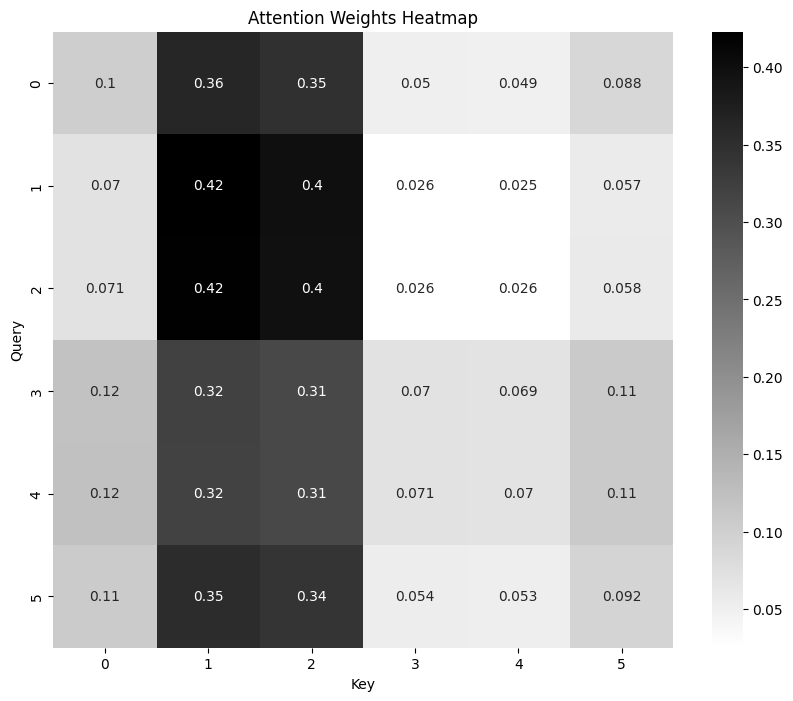

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

sa_v2 = SelfAttention_v2(d_in, d_out, debug=True)
outputs = sa_v2(inputs)

# Reproduce forward
x = inputs

keys = sa_v2.W_key(x)
queries = sa_v2.W_query(x)

attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

# Assuming attn_weights is a 2D tensor
attn_weights_np = attn_weights.detach().numpy() # Convert to numpy array if it's a tensor

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attn_weights_np, annot=True, cmap='gray_r', cbar=True, vmin=attn_weights_np.min(), vmax=attn_weights_np.max())
plt.title('Attention Weights Heatmap')
plt.xlabel('Key')
plt.ylabel('Query')
plt.show()

In [143]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

In [ ]:
# Why scores favor the 2nd and 3rd input elements ? Because their summation is higher and the weight matrices are filled with 1s
# hence the dot product of the 2nd and 3rd input elements with the query element will be higher
inputs.sum(dim=1)

tensor([1.4700, 2.0800, 2.0600, 1.1300, 1.1200, 1.4000])

It all depends on the initialization of the weight matrices

### Dimensionality of Attention Scores in Cross-Attention

**Cross-Attention in Transformer Architectures**
In encoder-decoder models (e.g., for sequence-to-sequence tasks), the query comes from the decoder, and the keys and values come from the encoder. In this case:
- Query matrix dimensions: [target_length, d_model] (decoder-side sequence length)
- Key matrix dimensions: [source_length, d_model] (encoder-side sequence length)
- Resulting attention scores: [target_length, source_length]

## 3.5 Causal Attention

In [145]:
# Reuse the query and key weight matrices of the
# SelfAttention_v2 object from the previous section for convenience
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs) 
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1020, 0.3625, 0.3477, 0.0503, 0.0493, 0.0882],
        [0.0703, 0.4228, 0.3987, 0.0259, 0.0251, 0.0572],
        [0.0712, 0.4212, 0.3973, 0.0265, 0.0257, 0.0581],
        [0.1210, 0.3207, 0.3106, 0.0703, 0.0692, 0.1082],
        [0.1216, 0.3194, 0.3095, 0.0709, 0.0698, 0.1088],
        [0.1059, 0.3543, 0.3406, 0.0540, 0.0530, 0.0922]],
       grad_fn=<SoftmaxBackward0>)


- The simplest way to mask out future attention weights is by creating a mask via PyTorch's tril function with elements below the main diagonal (including the diagonal itself) set to 1 and above the main diagonal set to 0:

In [146]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [147]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1020, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0703, 0.4228, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0712, 0.4212, 0.3973, 0.0000, 0.0000, 0.0000],
        [0.1210, 0.3207, 0.3106, 0.0703, 0.0000, 0.0000],
        [0.1216, 0.3194, 0.3095, 0.0709, 0.0698, 0.0000],
        [0.1059, 0.3543, 0.3406, 0.0540, 0.0530, 0.0922]],
       grad_fn=<MulBackward0>)


- However, if the mask were applied after softmax, like above, it would disrupt the probability distribution created by softmax
- Softmax ensures that all output values sum to 1
- Masking after softmax would require re-normalizing the outputs to sum to 1 again, which complicates the process and might lead to unintended effects

### How to make the rows on Masked Attention scores sum to 1 to become Masked Attention Weights

In [148]:
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1425, 0.8575, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0801, 0.4734, 0.4466, 0.0000, 0.0000, 0.0000],
        [0.1471, 0.3899, 0.3776, 0.0854, 0.0000, 0.0000],
        [0.1364, 0.3584, 0.3472, 0.0796, 0.0783, 0.0000],
        [0.1059, 0.3543, 0.3406, 0.0540, 0.0530, 0.0922]],
       grad_fn=<DivBackward0>)


- So, instead of zeroing out attention weights above the diagonal and renormalizing the results, we can mask the unnormalized attention scores above the diagonal with **negative infinity** before they enter the softmax function:

In [151]:
mask.bool()

tensor([[False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True],
        [False, False, False, False, False, False]])

In [149]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[4.3218,   -inf,   -inf,   -inf,   -inf,   -inf],
        [6.1152, 8.6528,   -inf,   -inf,   -inf,   -inf],
        [6.0564, 8.5696, 8.4872,   -inf,   -inf,   -inf],
        [3.3222, 4.7008, 4.6556, 2.5538,   -inf,   -inf],
        [3.2928, 4.6592, 4.6144, 2.5312, 2.5088,   -inf],
        [4.1160, 5.8240, 5.7680, 3.1640, 3.1360, 3.9200]],
       grad_fn=<MaskedFillBackward0>)


In [150]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1425, 0.8575, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0801, 0.4734, 0.4466, 0.0000, 0.0000, 0.0000],
        [0.1471, 0.3899, 0.3776, 0.0854, 0.0000, 0.0000],
        [0.1364, 0.3584, 0.3472, 0.0796, 0.0783, 0.0000],
        [0.1059, 0.3543, 0.3406, 0.0540, 0.0530, 0.0922]],
       grad_fn=<SoftmaxBackward0>)


### Dropout

- In addition, we also apply dropout to reduce overfitting during training
- Dropout can be applied in several places:
  - for example, after computing the attention weights;
  - or after multiplying the attention weights with the value vectors
- Here, we will apply the dropout mask after computing the attention weights because it's more common

- Furthermore, in this specific example, we use a dropout rate of 50%, which means randomly masking out half of the attention weights. (When we train the GPT model later, we will use a lower dropout rate, such as 0.1 or 0.2

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/22.webp" width="400px">

In [152]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # dropout rate of 50%
example = torch.ones(6, 6) # create a matrix of ones

print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


- If we apply a dropout rate of 0.5 (50%), the non-dropped values will be scaled accordingly by a factor of 1/0.5 = 2
- The scaling is calculated by the formula 1 / (1 - `dropout_rate`)

In [153]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.7149, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8931, 0.0000, 0.0000, 0.0000],
        [0.2942, 0.7798, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2728, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7087, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


**Is This a Problem?**

In the training phase, this lack of normalization is not an issue. 

Dropout is intended to act as a regularizer by introducing noise into the network, helping prevent overfitting.

During inference, dropout is not applied, and the attention weights remain properly normalized.


**Why Dropout Scales The Weights ?**

To maintain the expected value of the remaining weights.

Dropout is designed to maintain the expected value of activations during training. If we don't rescale the remaining weights, the expected value of the outputs would decrease during training, which would lead to:
- **Underpowered activations**: Neuron activations would be systematically smaller during training compared to inference.
- **Mismatch between training and inference**: During training, activations would have a lower magnitude than during inference (when no dropout is applied). This discrepancy could lead to poor generalization.

<img src="imgs/dropout1.png" height="100%">
<img src="imgs/dropout2.png" height="100%">

### 3.5 Final Class

In [156]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

In [ ]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # 2 inputs with 6 tokens each, and each token has embedding dimension 3

# batch: [B, L, Di] (where B: batch size, L: sequence length, Di: embedding dimension in)

torch.Size([2, 6, 3])


In [157]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

In [158]:
torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

In [159]:
context_vecs = ca(batch)

In [ ]:
context_vecs.shape # [B, L, Do]

torch.Size([2, 6, 2])

In [163]:
context_vecs

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

## 3.6 Multi-Head Attention